# Unconditional Diffusers

* This Notebook is based on HF's Diffusion model course ([Part 1](https://github.com/huggingface/diffusion-models-class/tree/main/unit1)) and from the [Annotated diffusion notebook](https://huggingface.co/blog/annotated-diffusion).<br>
* We will re-implemente the DDPM from scratch with the discrete-time perspective (latent variable model).<br>
* We will then train our model and create a pipeline to generate images of bored apes.


## Diffusion process set-up (for images):
* a fixed (or predefined) **forward diffusion process $q$** of our choosing, that **gradually adds Gaussian noise** to an image, until you end up with pure noise<br> -> "generate the targets for our NN" (the image after applying t < T noise steps).
<p align="center">
    <img src="https://theaisummer.com/static/1f5f940d6d3f1e00b3777066f6695331/073e9/forward-diffusion.png" width="600" />
</p>

* a **learned reverse denoising diffusion process $p_\theta$**, where a neural network is **trained to gradually denoise** an image starting from pure noise, until you end up with an actual image.

<p align="center">
    <img src="https://drive.google.com/uc?id=1t5dUyJwgy2ZpDAqHXw7GhUAp2FE5BWHA" width="600" />
</p>


#### Variance Schedule:
The forward diffusion process gradually adds noise to an image from the real distribution, in a number of time steps $T$.<br>
This happens according to a **variance schedule** which determines how much noise is added at different timesteps.<br>
In the original DDPM authors employed a linear schedule:<br>

> We set the forward process variances to constants
increasing linearly from $\beta_1 = 10^{−4}$
to $\beta_T = 0.02$.

However, it was shown in ([Nichol et al., 2021](https://arxiv.org/abs/2102.09672)) that better results can be achieved when employing a **cosine schedule**. 
<br>
<br>

## Defining objective function:
* the **variational lower bound** (also called ELBO) can be used to minimize the negative log-likelihood with respect to ground truth data sample 
* refer to [this video](https://www.youtube.com/watch?v=fbLgFrlTnGU) and [this excellent blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) for in depth explanation

The training algorithm looks as follows:

<p align="center">
    <img src="https://drive.google.com/uc?id=1LJsdkZ3i1J32lmi9ONMqKFg5LMtpSfT4" width="400" />
</p>

In other words:
* we take a random sample $\mathbf{x}_0$ from the real unknown and possibily complex data distribution $q(\mathbf{x}_0)$
* we sample a noise level $t$ uniformally between $1$ and $T$ (i.e., a random time step)
* we sample some noise from a Gaussian distribution and corrupt the input by this noise at level $t$ using the nice property defined above
* the neural network is trained to predict this noise based on the corruped image $\mathbf{x}_t$, i.e. noise applied on $\mathbf{x}_0$ based on known schedule $\beta_t$

In reality, all of this is done on batches of data as one uses stochastic gradient descent to optimize neural networks.

## The Neural Network
The neural network needs to take in a noised image at a particular time step and return the predicted noise. Note that the predicted noise is a tensor that has the same size/resolution as the input image.
* Inspiration from Autoencoder : the encoder first encodes an image into a smaller hidden representation called the "bottleneck" layer, and the decoder then decodes that hidden representation back into an actual image.
* **U-Net** (residual connections between the encoder and decoder)
<p align="center">
    <img src="https://drive.google.com/uc?id=1_Hej_VTgdUWGsxxIuyZACCGjpbCGIUi6" width="400" />
</p>

## Unet building blocks:
* Position embeddings : sinusoidal position embeddings to encode t (inspired by the Transformer) which allows the NN to "know" at which particular time step (noise level) it is operating, for every image in a batch.
* ResNet or ConvNeXT blocks
* Attention module : Multi-head self-attention & [linear attention variant](https://github.com/lucidrains/linear-attention-transformer) 
* Group Normalization (before or after attention ?)


## SET UP 

In [1]:
import torch
import torchvision
import numpy as np
import pprint
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from datasets import load_dataset
from huggingface_hub import notebook_login

from train_framework.model import Unet, ResnetBlock, ConvNextBlock
from train_framework.utils import *
from train_framework.schedulers import *
#from sampling import *
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline

#%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow
# %%capture
# Git-LFS to upload your model checkpoints
# !sudo apt -qq install git-lfs
!git config --global credential.helper store
!nvidia-smi -L

/home/dev/.pyenv/versions/3.8.12/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Invoking __init__.py for train_framework


2022-12-23 13:17:50.581881: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/tensorRT/lib::/usr/local/cuda-11.7/lib64::/usr/lib/x86_64-linux-gnu:
2022-12-23 13:17:50.581997: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/tensorRT/lib::/usr/local/cuda-11.7/lib64::/usr/lib/x86_64-linux-gnu:
2022-12-23 13:17:50.582006: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-370cb47b-508f-8165-4a90-3f747631bc7e)


In [2]:
# Get Configuration 
config = get_config('config.yml')
set_seed(config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(config)

cuda
YamlNamespace(adam_beta1=0.95, adam_beta2=0.999, adam_epsilon=1e-08, adam_weight_decay=2e-06, cache_dir=None, checkpointing=False, checkpointing_steps=500, dataloader_num_workers=0, dataset_config_name=None, dataset_name='daspartho/bored-ape', ddpm_beta_schedule='squaredcos_cap_v2', ddpm_num_steps=1000, ema_inv_gamma=1.0, ema_max_decay=0.9999, ema_power=0.75, eval_batch_size=4, finetune=True, gradient_accumulation_steps=2, hub_model_id=None, hub_token=None, learning_rate=5e-06, local_rank=-1, log_images_every='steps', logger='wandb', logging_dir='logs', loss_type='l2', lr_scheduler='cosine', lr_warmup_steps=500, mixed_precision='no', nbr_channels=3, num_epochs=2, output_dir='ddpm-church-finetune-wikiart-256', prediction_type='epsilon', pretrained_model='google/ddpm-church-256', push_to_hub=False, resolution=256, resume_from_checkpoint=None, save_images_epochs=1, save_images_steps=250, save_model_epochs=1, save_model_every='steps', save_model_steps=1500, scheduler='ddim', seed=42, 

The core API of 🤗 Diffusers is divided into three main components:
1. **Pipelines**: high-level classes designed to rapidly generate samples from popular trained diffusion models in a user-friendly fashion.
2. **Models**: popular architectures for training new diffusion models, *e.g.* [UNet](https://arxiv.org/abs/1505.04597).
3. **Schedulers**: various techniques for generating images from noise during *inference* as well as to generate noisy images for *training*.

Let's build our own pipeline capable of generating small bored apes pictures.

## Dataset & preprocessing

In [3]:
dataset = load_dataset(config.dataset_name)

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((64, 64)),  # Resize
        #transforms.CenterCrop((config.image_shape[0], config.image_shape[1]))
        #transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1) --  Numpy array of shape HWC, divide by 255
        #transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
        transforms.Lambda(lambda t: (t * 2) - 1) # instead of normalize
    ]
)

rev_transform = transforms.Compose(
    [
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToTensor(),
        transforms.ToPILImage(),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset['train'], batch_size=config.train_batch_size, shuffle=True
)

Downloading:   0%|          | 0.00/819 [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /home/dev/.cache/huggingface/datasets/daspartho___parquet/daspartho--bored-ape-ca9d0af587988159/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
print(len(train_dataloader))
img_batch = next(iter(train_dataloader))
print(img_batch.keys())

2500
dict_keys(['images'])


1.   Load in some images from the training data
2.   Add noise, in different amounts. 
3.   Feed the noisy versions of the inputs into the model
4.   Evaluate how well the model does at denoising these inputs
5.   Use this information to update the model weights, and repeat

We'll explore these steps one by one and how to package everything up into a pipeline for easy sharing.

In [5]:
def batch_tensor_to_pil(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    #print(x[0])
    grid = torchvision.utils.make_grid(x)
    
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

Img shape: torch.Size([3, 64, 64])


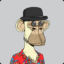

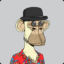

In [6]:
pt_img_test = next(iter(train_dataloader))["images"][0]
print(f"Img shape: {pt_img_test.shape}")
batch_tensor_to_pil(pt_img_test).show()
pil_img = rev_transform(pt_img_test)
pil_img.show()

We're sticking to a small dataset with 64 pixel images to keep training times manageable in this notebook and for a reduce compute& memory footprint.

## Define the forward diffusion process (Noise Scheduler)

The DDPM paper describes a corruption process that adds a small amount of noise for every 'timestep'. Given $x_{t-1}$ for some timestep, we can get the next (slightly more noisy) version $x_t$ with:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


That is, we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\beta_t$. This $\beta$ is defined for every t accoridng to some schedule, and determines how much noise is added per timestep. Now, we don't necessariy want to do this operation 500 times to get $x_{500}$ so we have another formula to get $x_t$ for any t given $x_0$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, {(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>


\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}

\begin{aligned}
\mathbf{z} &= \boldsymbol{\mu} + \boldsymbol{\sigma} \odot \boldsymbol{\epsilon} \text{, where } \boldsymbol{\epsilon} \sim \mathcal{N}(0, \boldsymbol{I}) & \scriptstyle{\text{; Reparameterization trick.}}
\end{aligned}

In [7]:
def extract_index(alphas, t, x_shape):
    """ Extract appropriate index (t) for a batch of indices. """
    batch_size = t.shape[0]
    out = alphas.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

# forward diffusion
def q_sample(betas, x_start, t, noise=None):
    component_list = get_components_list(betas)
    sqrt_alphas_cumprod = component_list[0]
    sqrt_one_min_alphas_cp = component_list[1]
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract_index(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract_index(sqrt_one_min_alphas_cp, t, x_start.shape)
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

### Using our schedulers

In [8]:
def plot_noise_scheduler(alphas_cumprod, title):
    f = plt.figure(figsize=[12, 5])
    plt.plot(alphas_cumprod, label=r"${\sqrt{\bar{\alpha}_t}}$")
    plt.plot((1 - alphas_cumprod), label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
    plt.legend(fontsize="x-large")
    plt.title(title)
    plt.show()

In [9]:
noise_sch_dict = {
    "cosine": cosine_beta_schedule,
    "linear": linear_beta_schedule,
    "quadratic": quadratic_beta_schedule,
    "sigmoid": sigmoid_beta_schedule,
}

In [10]:
def get_noisy_image(noise_sc, x_start, t):
  # add noise
  x_noisy = q_sample(noise_sc, x_start, t=t)
  return x_noisy

def get_noisy_pil_image(noise_sc, x_start, t, rev):
  # add noise
  x_noisy = q_sample(noise_sc, x_start, t=t)
  # turn back into PIL image
  noisy_image = rev(x_noisy.squeeze())
  return noisy_image

In [11]:
def plot(imgs, origi, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(100,100), nrows=num_rows, ncols=num_cols, squeeze=False)

    for row_idx, row in enumerate(imgs):

        row = [origi] + row if with_orig else row

        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

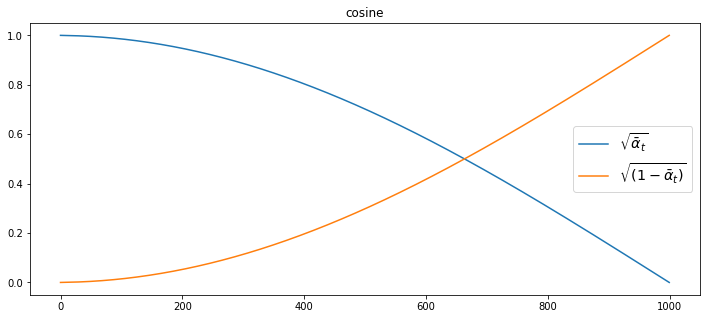

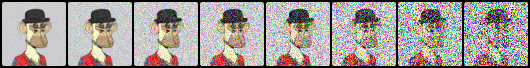

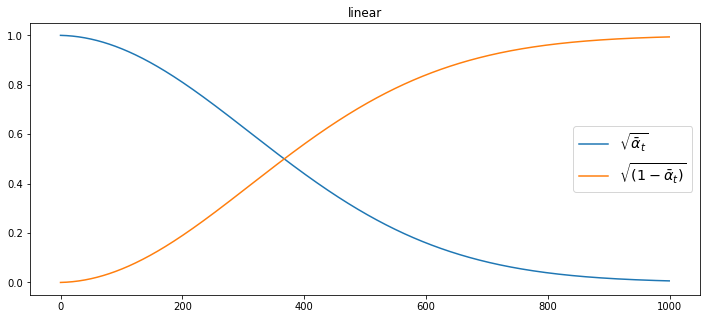

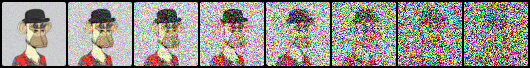

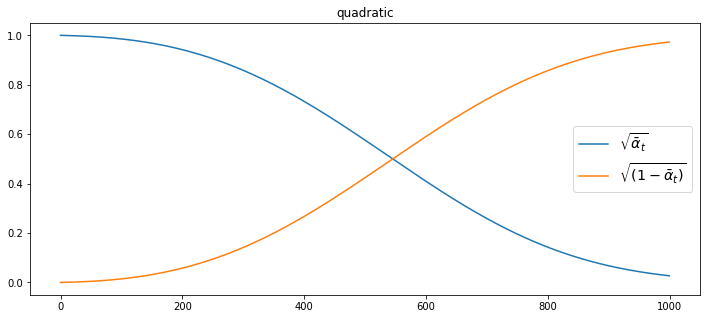

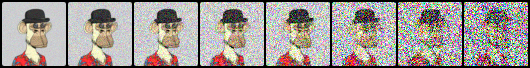

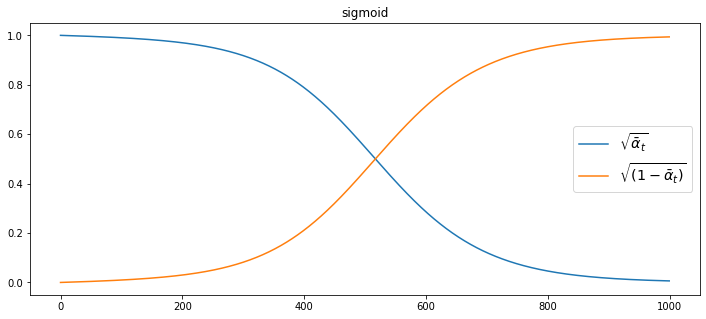

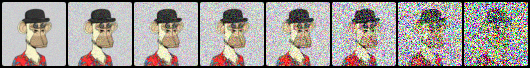

In [12]:
# take time step
t = torch.tensor([80])

for elem in noise_sch_dict.keys():
    noise_scheduler = noise_sch_dict[elem]
    noise_scheduler = noise_scheduler(config.ddpm_num_steps)
    alphas_cp = get_components_list(noise_scheduler)[0]
    plot_noise_scheduler(alphas_cp, elem)

    noisy_batch = [get_noisy_image(noise_scheduler, pt_img_test, torch.tensor([t])) for t in [10, 50, 100, 150, 200, 300, 400, 500]]
    noisy_batch = torch.stack(noisy_batch)
    batch_tensor_to_pil(noisy_batch).show()
    #noisy_pil_batch = [get_noisy_pil_image(noise_scheduler, pt_img_test, torch.tensor([t]), rev_transform) for t in [10, 50, 100, 150, 200, 300]]
    #plot(noisy_pil_batch, pil_img)
    

### Using the diffusers library

X shape: torch.Size([4, 3, 64, 64])


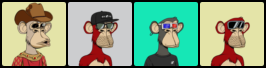

In [13]:
nbr = 8
n_examples = next(iter(train_dataloader))["images"].to(device)[:nbr]
print("X shape:", n_examples.shape)
batch_tensor_to_pil(n_examples).show()

In [14]:
noise_scheduler = DDPMScheduler(config.ddpm_num_steps, beta_schedule='squaredcos_cap_v2')

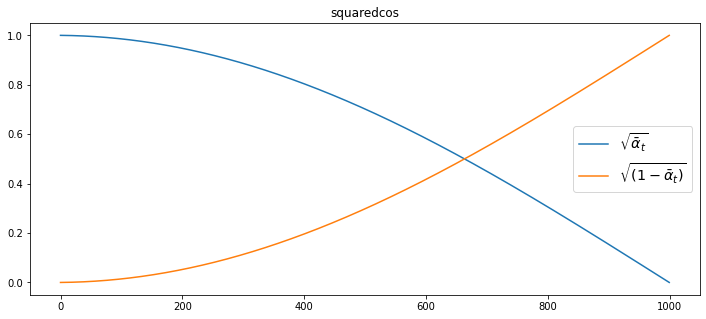

Noisy X shape torch.Size([4, 3, 64, 64])


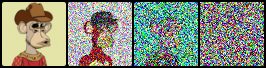

In [17]:
nbr = 4
plot_noise_scheduler(noise_scheduler.alphas_cumprod.cpu()** 0.5, 'squaredcos')
timesteps = torch.linspace(0, 999, nbr).long().to(device)
noise = torch.randn_like(n_examples)
noisy_img_batch = noise_scheduler.add_noise(n_examples, noise, timesteps)
print("Noisy X shape", noisy_img_batch.shape)
batch_tensor_to_pil(noisy_img_batch).show()

## Define the Model

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

In a nutshell:
- the model has the input image go through several blocks of ResNet layers, each of which halves the image size by 2
- then through the same number of blocks that upsample it again.
- there are skip connections linking the features on the downsample path to the corresponding layers in the upsample path.

A key feature of this model is that it predicts images of the same size as the input, which is exactly what we need here.

- the network takes a batch of noisy images of shape `(batch_size, num_channels, height, width)` and a batch of noise levels of shape `(batch_size, 1)` as input, and returns a tensor of shape `(batch_size, num_channels, height, width)`

In [18]:
my_model = Unet(
    dim=64,
    channels=config.nbr_channels,
    dim_mults=(1, 2, 4),
    block_type='resnet'
)
my_model.to(device)
print(my_model)

Unet(
  (init_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): GELU(approximate=none)
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (1): ResnetBlock(
        (mlp): Sequential(
 

In [20]:
## USING HF UNet2DModel
model = UNet2DModel(
    sample_size=64,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Con

In [31]:
x = torch.randn([2, 3, 64, 64]).to(device)
t = torch.randint(0, 999, (2,), device=device).long()

print(sum([p.numel() for p in my_model.parameters()]))
print(sum([p.numel() for p in model.parameters()]))

8256899
18536323


When dealing with higher-resolution inputs you may want to use more down and up-blocks, and keep the attention layers only at the lowest resolution (bottom) layers to reduce memory usage. We'll talk later about how you might experiment to find the best settings for your use-case.

We can check that passing in a batch of data and some random timesteps produces an output the same shape as the input data:

In [22]:
with torch.no_grad():
    model_prediction = model(n_examples, config.ddpm_num_steps).sample
model_prediction.shape

torch.Size([4, 3, 64, 64])

## Sampling

We'll sample from the model during training in order to track progress. Sampling is summarized in the paper as Algorithm 2:

<img src="https://drive.google.com/uc?id=1ij80f8TNBDzpKtqHjk_sh8o5aby3lmD7" width="500" />

Generating new images from a diffusion model happens by reversing the diffusion process: we start from $T$, where we sample pure noise from a Gaussian distribution, and then use our neural network to gradually denoise it (using the conditional probability it has learned), until we end up at time step $t = 0$. As shown above, we can derive a slighly less denoised image $\mathbf{x}_{t-1 }$ by plugging in the reparametrization of the mean, using our noise predictor. Remember that the variance is known ahead of time.

Ideally, we end up with an image that looks like it came from the real data distribution.
<br>
Here is a simplified version of the original implementation (that works just as well)

In [23]:
@torch.no_grad()
def p_sample(betas, model, x, t, t_index):
    
    component_list = get_components_list(betas)
    sqrt_one_min_alphas_cp = component_list[1]
    sqrt_recip_alphas = component_list[2]
    posterior_variance = component_list[3]

    betas_t = extract_index(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract_index(
        sqrt_one_min_alphas_cp, t, x.shape
    )
    sqrt_recip_alphas_t = extract_index(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract_index(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 


# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(config, model, noise_scheduler):
    
    device = next(model.parameters()).device

    b = config.batch_size
    b_shape = (b, config.image_shape[-1], 64, 64)
    # start from pure noise (for each example in the batch)
    img = torch.randn(b_shape, device=device)
    imgs = []
    #for i in tqdm(reversed(range(0, config.noise_train_steps)), desc='sampling loop time step', total=config.noise_train_steps):
    for i in reversed(range(0, config.noise_train_steps)):
        img = p_sample(noise_scheduler, model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs


@torch.no_grad()
def sample(config, model, noise_scheduler):
    return p_sample_loop(config, model, noise_scheduler)

## Training Loop

Below is a typical optimization loop in PyTorch, where we run through the data batch by batch and update the parameters of our model each step using an optimizer. 

For each batch of data, we
- Sample some random timesteps
- Noise the data accordingly
- Feed the noisy data through the model
- Compare the model predictions with the target (i.e. the noise in this case) using mean squared error as our loss function
- Update the model parameters via `loss.backward()` and `optimizer.step()`


In [11]:
#my_noise_scheduler  = noise_sch_dict['cosine']
#my_noise_scheduler = my_noise_scheduler (config.noise_train_steps)
#alphas_cp = get_components_list(my_noise_scheduler)[0]

In [24]:
def p_losses(denoise_model, ns, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(ns, x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [13]:
#from torchvision.utils import save_image
#from pathlib import Path

#def num_to_groups(num, divisor):
#    groups = num // divisor
#    remainder = num % divisor
#    arr = [divisor] * groups
#    if remainder > 0:
#        arr.append(remainder)
#    return arr

#results_folder = Path("./results")
#results_folder.mkdir(exist_ok = True)
#save_and_sample_every = 1000


#optimizer = torch.optim.AdamW(my_model.parameters(), lr=config.learning_rate)
#
#losses = []
#epoch_losses = []
#for epoch in range(config.n_epochs):
#    for step, batch in enumerate(train_dataloader):
#      optimizer.zero_grad()
#
#      batch_size = batch["images"].shape[0]
#      batch = batch["images"].to(device)
#      
#      # Algorithm 1 line 3: sample t uniformally for every example in the batch
#      t = torch.randint(0, config.noise_train_steps, (batch_size,), device=device).long()
#      loss = p_losses(my_model, my_noise_scheduler, batch, t, loss_type="l2")
#
#      loss.backward()
#      optimizer.step()
#
#      losses.append(loss.item())
#
#      # Update the model parameters with the optimizer
#      optimizer.step()
#
#      # save generated images
#      if step != 0 and step % save_and_sample_every == 0:
#        print("Loss:", loss.item())
#        milestone = step // save_and_sample_every
#        #batches = num_to_groups(4, batch_size)
#        #all_images_list = list(map(lambda n: sample(my_model, batch_size=n, channels=3), batches))
#        #all_images = torch.cat(all_images_list, dim=0)
#        #all_images = (all_images + 1) * 0.5
#        #save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)
#    
#    epoch_losses.append(sum(losses[-len(train_dataloader) :]) / len(train_dataloader))
#    
#for n_epoch, epoch_loss in enumerate(epoch_losses):
#    print(f"Epoch:{n_epoch+1}, loss: {epoch_loss}")

In [14]:
#fig, axs = plt.subplots(1, 2, figsize=(12, 4))
#axs[0].plot(losses)
#axs[1].plot(np.log(losses))
#plt.show()

The [official diffusers training example](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb) trains a larger model on this dataset at higher resolution, and is a good reference for what a less minimal training loop looks like:

In [25]:
noise_scheduler = DDPMScheduler(config.ddpm_num_steps, beta_schedule='squaredcos_cap_v2')

In [26]:
def get_loss(loss_type="l1"):

    if loss_type == 'l1':
        loss = F.l1_loss
    elif loss_type == 'l2':
        loss = F.mse_loss
    elif loss_type == "huber":
        loss = F.smooth_l1_loss
    else:
        raise NotImplementedError()

    return loss

In [27]:
# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

losses = []
epoch_losses = []
save_and_sample_every = 100
loss_fct = get_loss(config.loss_type)

##
grad_accumulation_steps = 2

for epoch in range(config.num_epochs):
    for step, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        batch = batch["images"].to(device)
        batch_size = batch.shape[0]

        # Sample noise to add to the images
        noise = torch.randn(batch.shape).to(batch.device)
        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (batch_size,), device=batch.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(batch, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        #loss = F.mse_loss(noise_pred, noise)
        loss = loss_fct(noise_pred, noise)

        #if step != 0 and step % save_and_sample_every == 0:
        #  print("Loss:", loss.item())

        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()

        ####
        # Exercise: See if you can add gradient accumulation to the training loop 
        # How does it perform? Think how you might adjust the learning rate based on the
        # number of gradient accumulation steps - should it stay the same as before? maybe can increase 
        # Gradient accumulation: -> get the same benefit we would get from using a larger batch size _without_ the memory requirements skyrocketing
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    #epoch_losses.append(sum(losses[-len(train_dataloader) :]) / len(train_dataloader))    
    loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")
    
    
#for n_epoch, epoch_loss in enumerate(epoch_losses):
#    print(f"Epoch:{n_epoch+1}, loss: {epoch_loss}")

Epoch:1, loss: 0.09247895753085614
Epoch:2, loss: 0.0474489340364933
Epoch:3, loss: 0.03614333626925945
Epoch:4, loss: 0.030158080585300923
Epoch:5, loss: 0.025698951832950116
Epoch:6, loss: 0.022631989717483522
Epoch:7, loss: 0.020391260367631912
Epoch:8, loss: 0.020495171982795
Epoch:9, loss: 0.016745398146659134
Epoch:10, loss: 0.017631826446205378
Epoch:11, loss: 0.016057855098694562
Epoch:12, loss: 0.015418897420167922
Epoch:13, loss: 0.016590665190294385
Epoch:14, loss: 0.01393673344142735
Epoch:15, loss: 0.01377690325640142
Epoch:16, loss: 0.012456720664352178
Epoch:17, loss: 0.01402024622298777
Epoch:18, loss: 0.011391037674248218
Epoch:19, loss: 0.009979966963455081
Epoch:20, loss: 0.012610873819887639
Epoch:21, loss: 0.01123339933156967
Epoch:22, loss: 0.010648426434770226
Epoch:23, loss: 0.010694055860862136
Epoch:24, loss: 0.009766428783163429
Epoch:25, loss: 0.009689510197937488
Epoch:26, loss: 0.009691871821507811
Epoch:27, loss: 0.01084772806353867
Epoch:28, loss: 0.0091

Plotting the loss, we see that the model rapidly improves initially and then continues to get better at a slower rate (which is more obvious if we use a log scale as shown on the right):

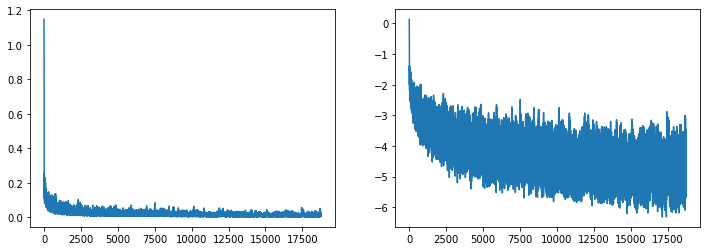

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

### Writing a Sampling Loop

We will implement the same logic as the `DDPMPipeline` pipeline.
If you inspect the forward method of that pipeline you'll be able to see what is happening when we run `image_pipe()`:

We begin with random noise, and run through the scheduler timesteps from most to least noisy, removing a small amount of noise each step based on the model prediction:

In [27]:
def plot_samples(samples, batch_size):
    nrows = batch_size // 8
    fig, axs = plt.subplots(figsize=(12, 12), nrows=nrows, ncols=8, squeeze=True)
    for i, ax in enumerate(axs.flat):
        image = ((samples[i] + 1) * 0.5).astype(np.float32)
        image = np.clip(image, 0, 1)
        image = np.transpose(image, axes=[1, 2, 0])
        ax.imshow(image)
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.tight_layout()
    fig

In [30]:
# sample 64 images
#config.batch_size = 64
#samples = sample(config, my_model, my_noise_scheduler)
#plot_samples(samples[-1], 64)

#import matplotlib.animation as animation
#
#random_index = 53
#
#fig = plt.figure()
#ims = []
#for i in range(timesteps):
#    im = plt.imshow(samples[i][random_index].reshape(config.image_shape[0], config.image_shape[1], config.image_shape[-1]), cmap="gray", animated=True)
#    ims.append([im])
#
#animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
#animate.save('diffusion.gif')
#plt.show()

(16, 3, 64, 64)


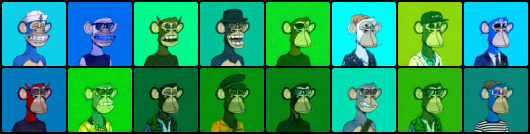

In [31]:
# Random starting point (8 random images):
sample_shape = (config.batch_size, config.image_shape[-1], 64, 64)
print(sample_shape)
img_sample = torch.randn(sample_shape).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(img_sample, t).sample
    # Update img_sample with step
    img_sample = noise_scheduler.step(residual, t, img_sample).prev_sample

batch_tensor_to_pil(img_sample).show()

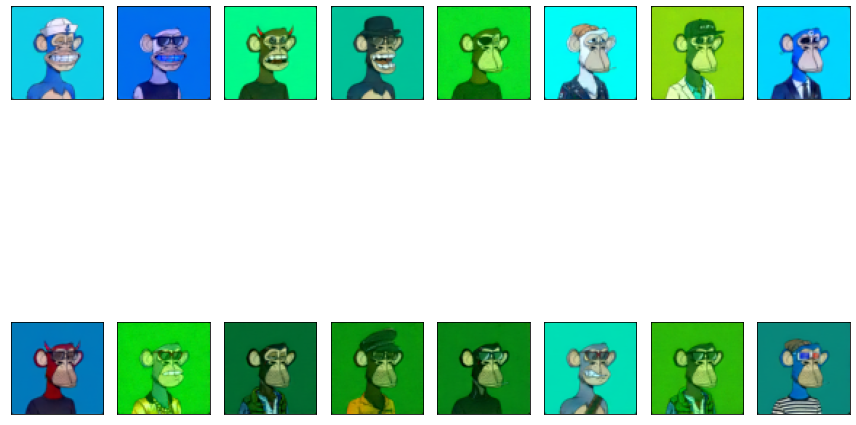

In [32]:
plot_samples(img_sample.detach().cpu().numpy(), 16)

The `noise_scheduler.step()` function does the maths required to update `sample` appropriately. There are a number of sampling methods - in the next unit we'll see how we can swap in a different sampler to speed up image generation with existing models, and talk more about the theory behind sampling from diffusion models.

### Option 1: Creating a pipeline:

In [43]:
image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

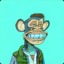

In [44]:
pipeline_output = image_pipe()
pipeline_output.images[0]

We can save a pipeline to a local folder like so:

In [45]:
image_pipe.save_pretrained("diff_bored_apes_64")

Inspecting the folder contents:

In [46]:
!ls diff_bored_apes_64/

model_index.json  scheduler  unet


The `scheduler` and `unet` subfolders contain everything needed to re-create those components. For example, inside the `unet` folder you'll find the model weights (`diffusion_pytorch_model.bin`) alongside a config file which specifies the UNet architecture. 

In [37]:
!ls diff_bored_apes_64/unet/

config.json  diffusion_pytorch_model.bin


Together, these files contain everything needed to recreate the pipeline. You can manually upload them to the hub to share the pipeline with others, or check out the code to do this via the API in the next section.

In [48]:
# ??image_pipe.forward

## Step 7: Push your model to the Hub

In the example above we saved our pipeline to a local folder. To push our model to the Hub, we will need to model repository to push our files to. We'll determine the repository name from the model ID we want to give our model (feel free to replace the `model_name` with your own choice; it just needs to contain your username, which is what the function `get_full_repo_name()` does):

In [28]:
from huggingface_hub import get_full_repo_name
from huggingface_hub import HfApi, create_repo
from huggingface_hub import ModelCard
from diffusers import DDPMPipeline

In [28]:
notebook_login()

In [ ]:
hub_model_id = get_full_repo_name("diff-bored-apes-64")
hub_model_id

'CCMat/diff-bored-apes-64'

Next, create a model repository on the 🤗 Hub and push our model:

In [51]:
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path="diff_bored_apes_64/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path="diff_bored_apes_64/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="diff_bored_apes_64/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

'https://huggingface.co/CCMat/diff-bored-apes-64/blob/main/model_index.json'

In [52]:
content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of bored apes 🦧.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

'https://huggingface.co/CCMat/diff-bored-apes-64/blob/main/README.md'

Now that the model is on the Hub, you can download it from anywhere by using the `from_pretrained()` method of the `DDPMPipeline` as follows"

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

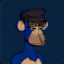

In [26]:
image_pipe = DDPMPipeline.from_pretrained(hub_model_id)
pipeline_output = image_pipe()
pipeline_output.images[0]

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#pipeline = DDPMPipeline.from_pretrained(hub_model_id).to(device)
#images = pipeline(batch_size=16).images
#make_grid(images).show()
#image = images[0]
#image.show()

Great it works!

# Scaling up with 🤗 Accelerate

This notebook was made for learning purposes, and as such is as minimal and clean as possible. Because of this, we omitted some of the things you might want if you were to try training a larger model on much more data, such as multi-GPU support, logging of progress and example images, gradient checkpointing to support larger batch sizes, automatic uploading of models and so on. Thankfully most of these features are available in the example training script [here](https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py).


In [30]:
# Let's give our new model a name for the Hub
hub_model_id = get_full_repo_name('diff-bored-apes-128')
hub_model_id

'CCMat/diff-bored-apes-128'

This still takes a lot of time, and printing out a one-line update every epoch is not enough feedback to give us a good idea of what is going on. We should probably:


*   Generate some samples occasionally to visually examine the performance qualitatively as the model trains
*   Log things like the loss and sample generations during training, perhaps using something like Weights and Biases or tensorboard.

In [ ]:
!accelerate launch train_unconditional.py --config config.yml

In [28]:
!accelerate launch train_unconditional.py \
  --dataset_name=config.dataset_name \
  --output_dir=config.output_dir \
  --resolution=config.resolution \
  --train_batch_size=config.batch_size \
  --num_epochs=config.num_epochs \
  --save_images_epochs=config.save_images_epochs \
  --gradient_accumulation_steps=config.gradient_accumulation_steps \
  --learning_rate=config.learning_rate \
  --lr_scheduler=config.lr_scheduler \
  --lr_warmup_steps=config.lr_warmup_steps \
  --adam_weight_decay=config.adam_weight_decay \
  --mixed_precision=config.mixed_precision

/home/dev/.pyenv/versions/3.8.12/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
2022-12-20 19:18:54.475295: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/tensorRT/lib::/usr/local/cuda-11.7/lib64::/usr/lib/x86_64-linux-gnu:
2022-12-20 19:18:54.475434: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/tensorRT/lib::/usr/local/cuda-11.7/lib64::/usr/lib/x86_64-linux-gnu:
2

As before, let's push the model to the Hub and create a nice model card (and feel free to edit it as you wish!):

In [29]:
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{config.m_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{config.m_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{config.m_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---


This model is a diffusion model for unconditional image generation of bored apes 🦧.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

'https://huggingface.co/CCMat/diff-bored-apes-128/blob/main/README.md'

About 45 minutes later, this is the result:

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline = DDPMPipeline.from_pretrained(hub_model_id).to(device)
images = pipeline(batch_size=config.batch_size).images

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

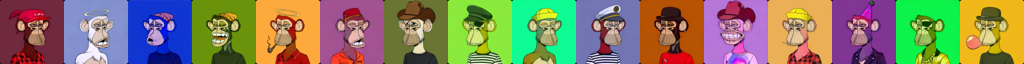

In [37]:
make_grid(images).show()

In [40]:
# run pipeline in inference
image = images[4]
# save image
image.save("bored_ape.png")

Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/300 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/786 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455M [00:00<?, ?B/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

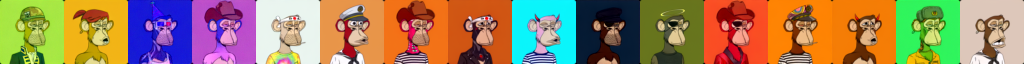

In [29]:
pipeline = DDPMPipeline.from_pretrained('CCMat/diff-bored-apes-64').to(device)
images = pipeline(batch_size=16).images
make_grid(images).show()

**Exercise:** See if you can find training/model settings that give good results in as little time as possible, and share your findings with the community. Dig around in the script to see if you can understand the code, and ask for clarification on anything that looks confusing.

- Check out the [Diffusion Models from Scratch](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/02_diffusion_models_from_scratch.ipynb) notebook for a different take on the core ideas we've covered
